# Using A Convolutional Nueral Network to Predict Alzhiemer's
Hunter Owen

# Project overview

The objective of this project was to see if I could create a CNN model that could predict 4 classifications of Alzheimer's to with an accuracy over 80%. Alzheimer’s is one of the more heartbreaking diseases that humans get; People who’ve known you for you’re entire life cant remember your name or who you are anymore. As brain scans and treatments for Alzheimers get better its important that there are models that can help MRI technicians and doctors diagnose patients.

# Data

The data we used can be found at [Kaggle](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images)<br>
The data can also be downloaded using kaggle api shown in this [notebook](../exploratory/imprt_data.ipynb).

The Target being predicted is Normal, Very Mild Alzheimers, Mild Alzhiemers, and Moderate Alzheimers.<br> 
There was a significant class imbalance on the Moderate Alzheimers class. 

Normal: 3200<br>
Very Mild: 2240<br>
Mild: 896<br>
Moderate: 64<br>

# Final Model & Results

###  97% Accuracy & 99% AUC on test

#### Model: Keras convolutional neural network
>Parameters used to achieve final model:                                     
> * learning_rate = 1e-4
> * optimizer = RMSprop
> * loss = categorical_crossentropy
> * Class weights = {Mild: 1.7, Moderate: 25.4, Normal: 0.5, very Mild: 0.7}
> * Epochs = 200

#### Model: Layers

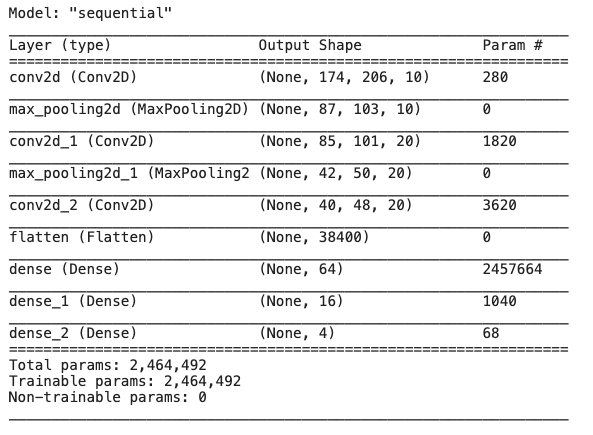

In [18]:
IMG(filename = "figures/ModelSummary.png", width = 900, height = 450)

#### Test Confusion Matrix 

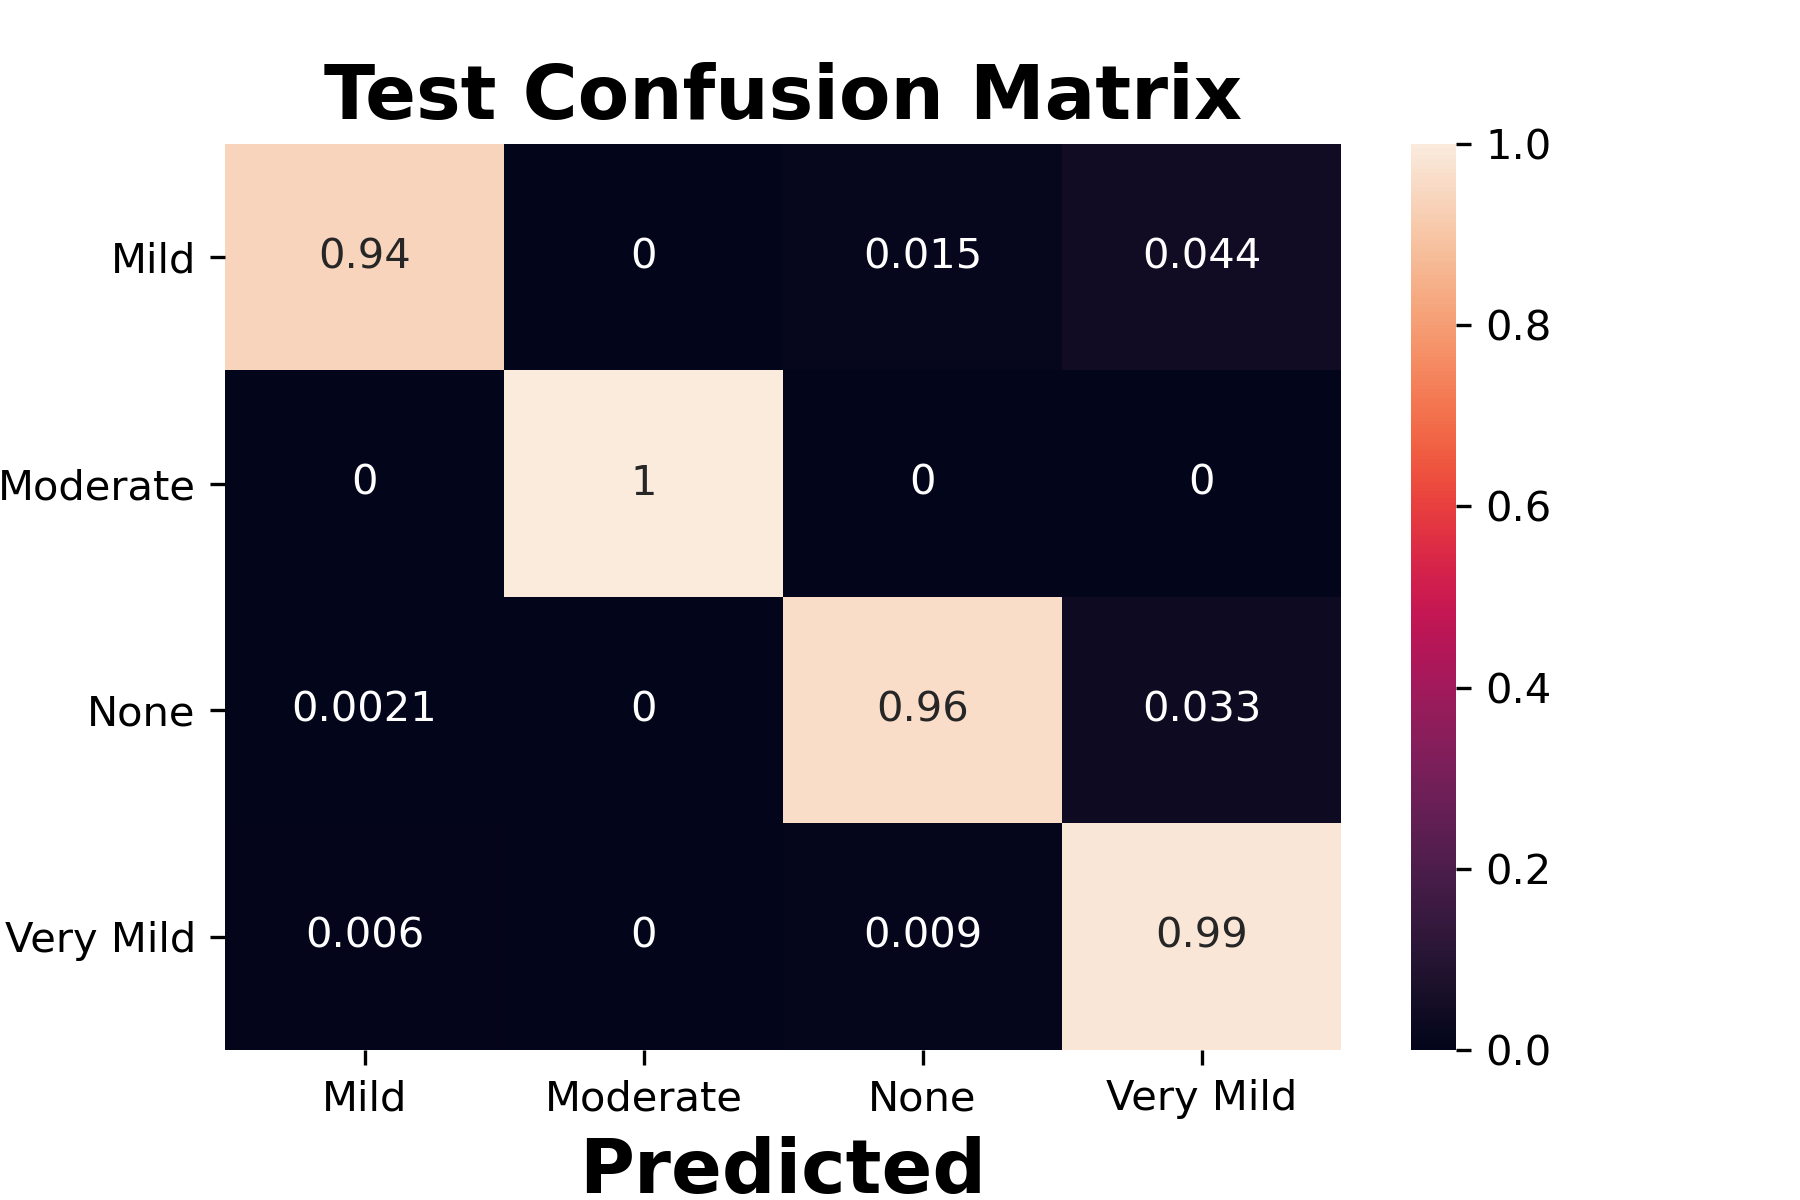

In [120]:
IMG(filename = "figures/Confusion_matrix_test.png", width = 900, height = 450)

# Imports

In [95]:
import json
import glob

from IPython.display import Image as IMG
from PIL import Image
from scipy import ndimage

from sklearn.utils import compute_class_weight
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras.models import load_model

#modeling
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation,Flatten, Dense
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

# Visual packages
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.mymods import Vis_results2, Vis_results_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Looking at Images of DataSet

To the untrained Eye it looks like these images are all very similar and hard to tell what separates one class from another. Luckily my model was able to predict with high accuracy as well as show what features it finds important.

Found 4483 files belonging to 4 classes.


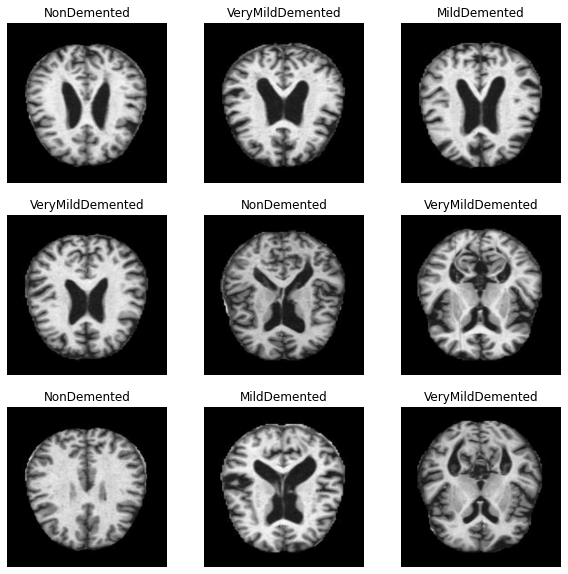

In [26]:
# Creating image dataset from train path
Image_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '../../src/data2/train',
  seed=123) 
class_names = Image_ds.class_names # A list of the class names

# Plot of the 9 random images across all classes. 
plt.figure(figsize=(10, 10))
for images, labels in Image_ds.take(1):
    for i in range(9):
         ax = plt.subplot(3, 3, i + 1)
         plt.imshow(images[i].numpy().astype("uint8"))
         plt.title(class_names[labels[i]])
         plt.axis("off")

# Preprocessing

Earlier iterations of models can be found in exploratory notebooks. I tried a variety of models with test size (64,64), (128,128), and finally (178, 208). Using a size of (178,208) took longer to train, but would almost always have better results which is why I choose it. For the batch size I didn’t want too large of a batch size because they have a chance at getting stuck in local minimums and thus leads to poorer generalizations. I didn’t want to use to small of a batch size because the computational time was to much. On the simpler models in my exploratory notebook I stuck to batch size less than 64, but once I started getting more advance models I used 64 and was able to achieve great results without the cost of extra computational time. For the imbalanced classes I decided to use class weights instead of data augmentation during my training as I was getting better results and not using a ton of extra computational time for data augmentation. The image was rescaled to normalize the pixels between 0 and 1. Beyond what is below there were no further preprocessing steps taken.

In [45]:
# File Paths of directories
train_dir = '../../src/data2/train'
val_dir = '../../src/data2/val'
test_dir = '../../src/data2/test'

# Constants
num_of_test_samples = len(glob.glob('../../src/data2/test/*/*.jpg'))
batch_size = 64
target_size = (176, 208)
class_weights = compute_class_weight('balanced', 
                                     np.unique(train_generator.classes), 
                                     train_generator.classes)

# Rescales the pixel values between 0 and 1 so keras can work with it
# Not going to use image Augmentation as results were high enough without
dagenerator = ImageDataGenerator(rescale=1./255)

train_generator  = dagenerator.flow_from_directory(directory = train_dir,
                                                   target_size = target_size,
                                                   batch_size = batch_size)

val_generator = dagenerator.flow_from_directory(directory = val_dir,
                                                  target_size = target_size,
                                                  shuffle = False,
                                                  batch_size = batch_size)

test_generator = dagenerator.flow_from_directory(directory = test_dir,
                                                  target_size = target_size,
                                                  shuffle = False,
                                                  batch_size = num_of_test_samples)

Found 4483 images belonging to 4 classes.
Found 960 images belonging to 4 classes.
Found 961 images belonging to 4 classes.


# Final Model

For this project I solely used Keras to do modeling. This model which performed very well ended up being a simpler model in terms of depth and kernel size. For kernel size it was relatively small, only size 10 for the first layer. This surprised me as other models that used larger kernels for the 1st, 2nd, and 3rd convolutional layers performed worse and took longer to run. Even though it’s hard for me to tell which classification the image belongs to I imagine these images are rather easily for a CNN so having an overly complex and deep CNN is wasted on this dataset. For the activation function in each layer I stuck to Relu as it tends to train quicker and perform better than the other activation functions. When adding the Dense layers I imagined that Id need some sort of regularization or dropout layer behind it to prevent overfitting, however this model performed better than models with dropout layers on the validation and test proving it didn’t need them. Making a more dense convolutional layers and less dense full layer with dropout layer might have worked as well. I think the reason my model performed well was because it wasn’t overly dense throughout the layers which allowed it to perform well without drop out layers or regularization. For the loss function I stuck with Categorical cross entropy as it a common one used for multi classification problems. It penalizes the predictions that are confident but wrong quite heavily. The optimizer used was RMSprop as it gave me the best results when compared to RMS, SGD and Adam. It seemed to always converge quicker when trying different models. An interesting article desribing RMSprop can be found [here](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a).

In [53]:
# Final Model using Conv2D layers, pooling and Dense layers
# Model is saved. If Interested in epochs go to exploratory 4_models.ipynb notebook
# If this is run could take up to 2 hours

model = Sequential()

model.add(Conv2D(10, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify

# Going to use RMS for model as it converged quicker than other optimizers
model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(learning_rate = 1e-4),
              metrics= ['acc', 'AUC'])


#Fit perameters
# stopped epoch if accuracy doesnt increase in 15 rounds
earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 15, 
                              restore_best_weights= True,
                              verbose = 1)

#Saving best weights based on validation accuracy
filepath = '../../src/best_weights_mod1.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc',
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callbacks = [earlystopping, checkpoint]

# history = model.fit_generator(
#         generator =train_generator,
#         validation_data = val_generator,
#         class_weight = dict_class_weights,
#         callbacks = callbacks, 
#         epochs=200)



# Loading in final model and its history so we dont have to run above
with open('../../src/history_mod1.json') as f:
    history = json.load(f)
model = load_model('../../src/best_weights_mod1.hdf5')

# Looking at Final Models Activation Layer

Its interesting to see what the filters look like for each of the nodes in my first layer. This doesn't necessarily help improve modeling, but you can get an idea of how the model is picking up on features and patterns within the image. As you can see different parts are more obvious in each of the pictures. Some of the filters clearly show the edges while in other instances they are very hard to see.

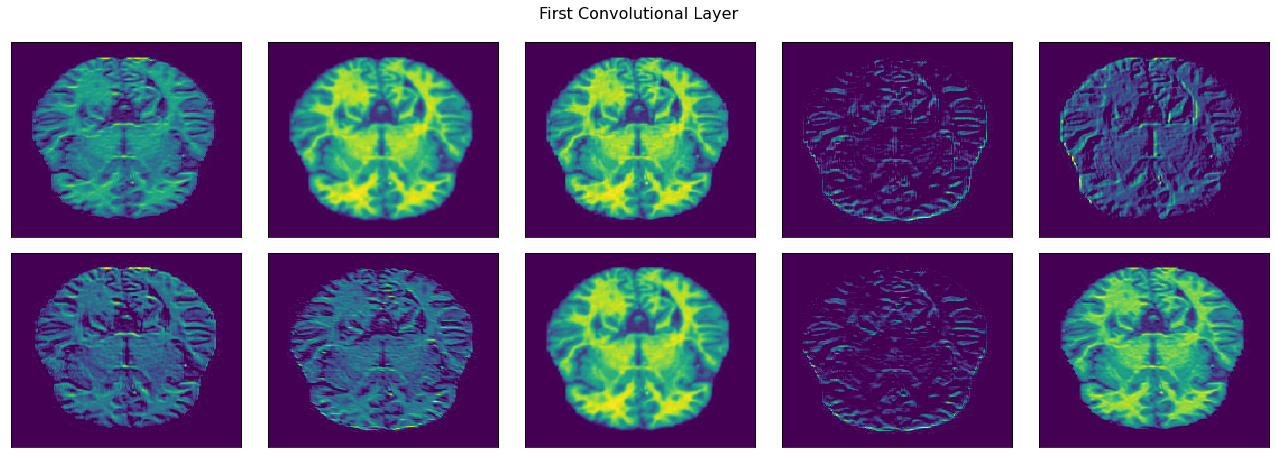

In [129]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

img_path = '../../src/data2/train/NonDemented/nondem100.jpg'
img = image.load_img(img_path, target_size=(176, 208))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)


activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]  #The first activation layer 

fig, axes = plt.subplots(2, 5, figsize=(18,6))
fig.suptitle('First Convolutional Layer', fontsize=16, y = 1.05)
for i in range(10):
    row = i//5
    column = i%5
    ax = axes[row, column]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig('figures/Channels', dpi = 300)

Again, Looking at the Convolutional and pooling layers doesnt necissarily help deduce how to improve modeling, but it is interesting to see how an image is changed as it goes through the series of layers. Below you can see as it goes through each layer it is getting more general 

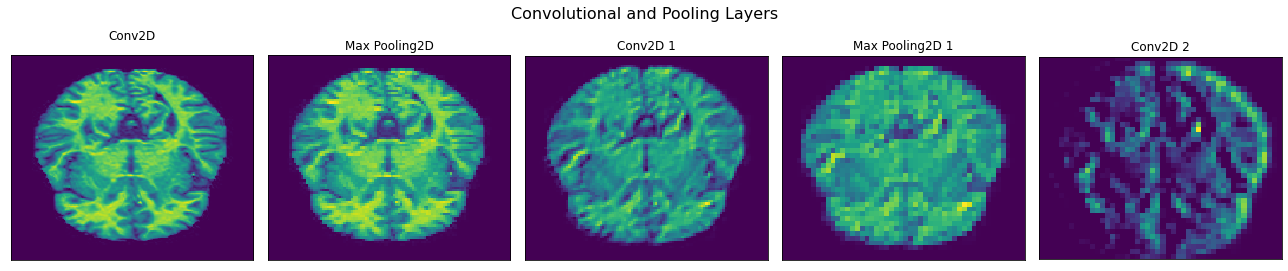

In [125]:
fig, axes = plt.subplots(1,5, figsize=(18,6))
fig.suptitle('Convolutional and Pooling Layers', fontsize=16, y = .85)
layer_names = []
for layer in model.layers[:5]:
    layer_names.append(layer.name)

for i in range(5):
    ax = axes[i]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 9], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(f'{layer_names[i].replace("_"," ").title()}')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

# Model Results

I was able to achieve a 98% accuracy on my validation set and a 97% on my test set. From both the accuracy and loss graphs you can see around 40 epochs it seemed that the model converged and the weights were pretty close to optimized as there was a flattening for both the train and validation set. The images that My model got wrong the most on the test set was Normal and Mild Alzheimers. Both in which were predicting very mild for them which was the closest in classification. Alzheimers is a hard disease to diagnose so I didn’t focus to much on lowering false negatives (predicting the patient doesn’t have it yet they do).  Often a 2nd opinion is needed and many other aptitude tests are used rather than just an MRI image. Because of that I just focused on Accuracy of the model as a whole. AUC is another metric that I was using through model iterations to determine performance. AUC is often used when there is large class imbalance because it doesn’t skew the performance as much as accuracy can. However I got 100% accuracy on my smallest class size so it neglected the reason for using AUC to show my performance. 

-----------------------Val Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.98      0.99      0.98       134
    Moderate       1.00      1.00      1.00         9
        None       0.99      0.98      0.98       480
   Very Mild       0.97      0.98      0.97       337

    accuracy                           0.98       960
   macro avg       0.98      0.99      0.98       960
weighted avg       0.98      0.98      0.98       960



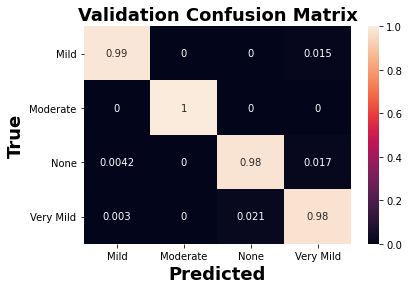

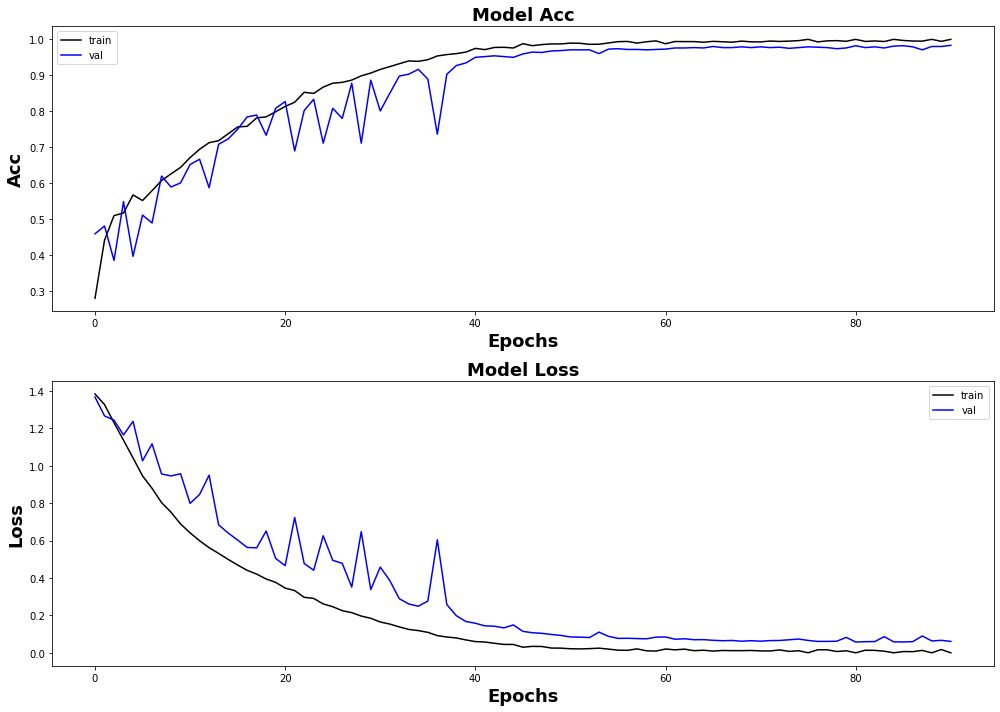

In [135]:
Vis_results2(model, history, val_generator, val_generator.n, batch_size)

-----------------------Test Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.98      0.94      0.96       135
    Moderate       1.00      1.00      1.00        11
        None       0.99      0.96      0.98       480
   Very Mild       0.94      0.99      0.96       335

    accuracy                           0.97       961
   macro avg       0.98      0.97      0.97       961
weighted avg       0.97      0.97      0.97       961



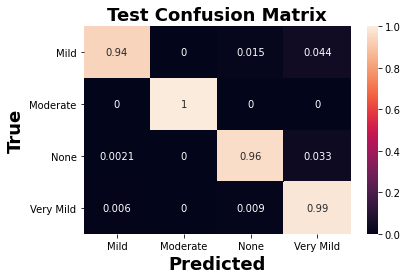

In [121]:
y_pred, Y_pred = Vis_results_test(model, history, test_generator)

## Wrong Predictions by Final Model

Below is some images of what my model predicted wrong. The ones it got wrong were classes that were most similar to one another which is a good thing and likely what actual MRI technicians would mess up on as well.

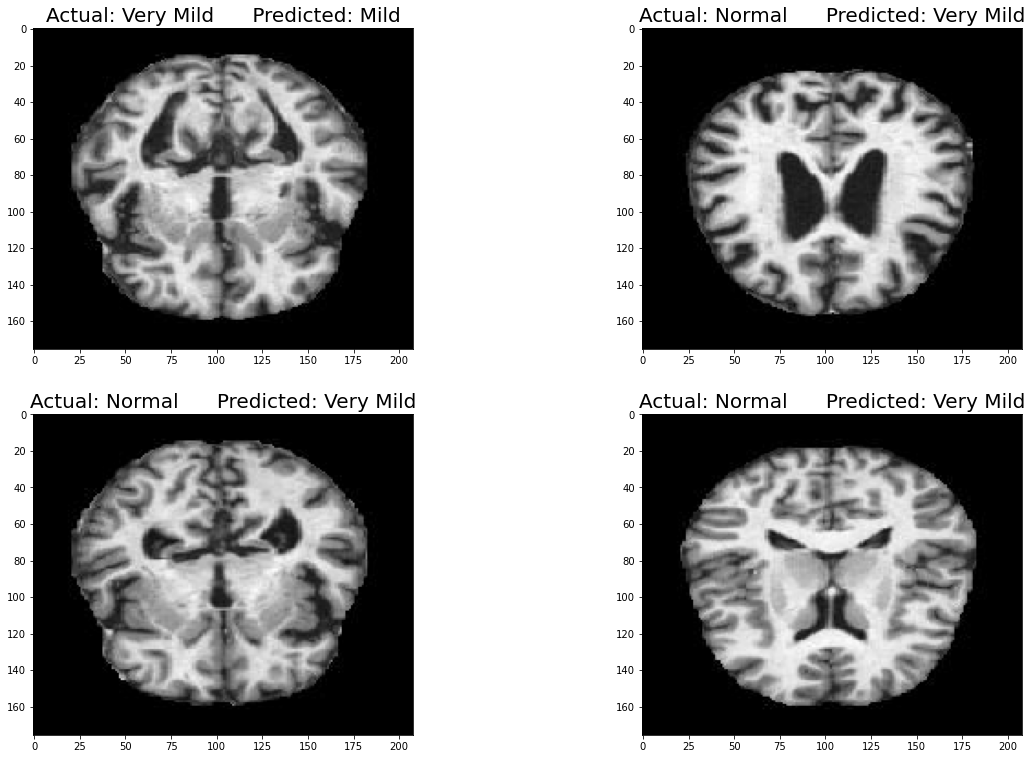

In [92]:
# the Indices of the labels that were incorrect    
incorrects = np.nonzero(y_pred != test_generator.classes)[0]     

ncols=2
nrows=2

a, b = test_generator[0]    
# shows us a random assortment of what our model got wrong    
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (20,13))
for row in range(axs.shape[0]):
    for col in range(axs.shape[1]):
        for i in np.random.choice(incorrects, ncols):
            img = a[i]
            class_name = ['Mild', 'Moderate', 'Normal', 'Very Mild']
            act_classname = class_name[test_generator.classes[i]]
            pred_classname = class_name[y_pred[i]]

            axs[row,col].imshow(img)
            axs[row,col].set_title(f'Actual: {act_classname}      Predicted: {pred_classname}', fontsize = 20)

## Looking at Features my model finds Important

I used the lime library to extract what features my model found important when classifying these images. I wanted to compare them to what actual doctors/MRI techs look at. Cited from [radiologyinfo.org](https://www.radiologyinfo.org/en/info.cfm?pg=alzheimers#:~:text=MRI%20can%20detect%20brain%20abnormalities,the%20brain%20may%20be%20normal). MRI can be used to look at temporal and parietal lobes. The Image shown below can is taken from [here](https://radiopaedia.org/articles/temporal-lobe?lang=us). The Yellow and blue area are the important areas that doctors often look at for shrinkage. 

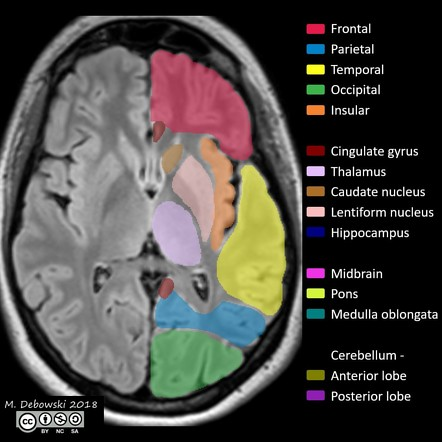

In [118]:
IMG(filename = "figures/Brain_diagram.png", width = 400, height = 450)

Even though I had such a high accuracy I wanted to see what my model was predicting incorrectly. This figure is showing the probabilities of some of my models incorrect predictions and what its looking at. Largely what doctors look for when diagnosing patients is a shrinkage of the Temporal and Parietal lobes. Those are Shown by yellow and blue areas above, and for the most part my model seems to be looking at those areas for a lot of the images. Its also noted that for many of the images its predicting wrong there is a decently high probability for it being the correct class. For example the first image is Mild alzhiemers and model predicted it about 30 percent likely to be Mild. The 3rd image was a normal brain and my model predicts 45 percent likely to be normal. This is a sign that my model even when predicting wrong its still doing a fairly good job. 


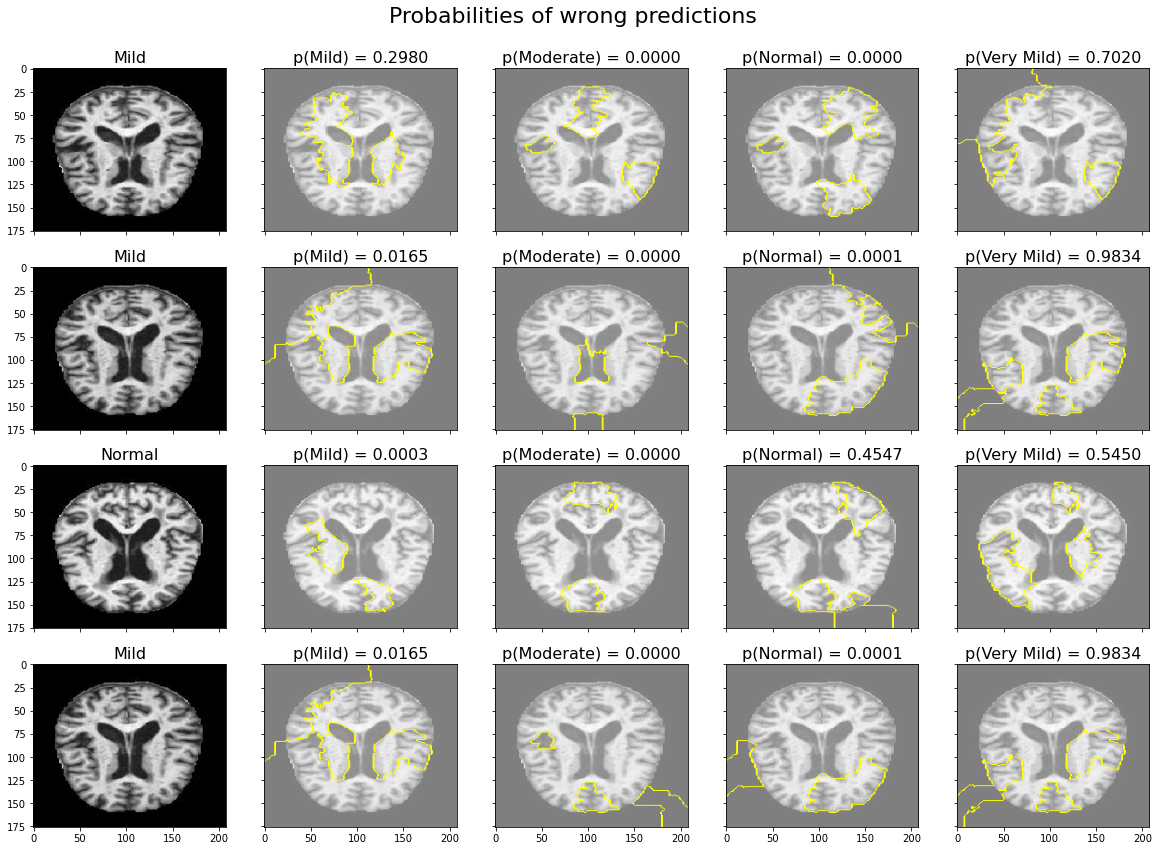

In [141]:
explainer = lime_image.LimeImageExplainer(random_state=42);

ncols = 5
nrows = 4 

a, b = test_generator[0] # a is now equal to an array of all the images in the test generator
indecies = np.random.choice(incorrects, ncols) # Random selecting of wrongly predicted images. ncols is the how many images
class_name = ['Mild', 'Moderate', 'Normal', 'Very Mild']


fig, ax = plt.subplots(nrows, ncols, sharex='col', sharey='row')
fig.set_figwidth(20)
fig.set_figheight(14)
fig.suptitle('Probabilities of wrong predictions', fontsize = 22, y = .94)


for j in range(nrows):
    explanation = explainer.explain_instance(a[indecies][j], 
                                             model.predict, 
                                             top_labels=4, hide_color=0, num_samples=200, 
                                             random_seed=42);
    ax[j,0].imshow(a[indecies][j]);
    ax[j,0].set_title(class_name[test_generator.classes[indecies][j]], fontsize = 16);
    for i in range(ncols - 1):
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                    num_features=3, hide_rest=False);
        ax[j,i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask));
        ax[j,i+1].set_title('p({}) = {:.4f}'.format(class_name[i], Y_pred[indecies[j]][i]), fontsize = 16);


plt.savefig(f'../report/figures/Lime_wrong_preds', dpi = 100)

## Features Model is looking at When Predicting Correct

Likewise, when predicting the correct classes it seems to focus on the Temporal and Parietal lobes largely. 

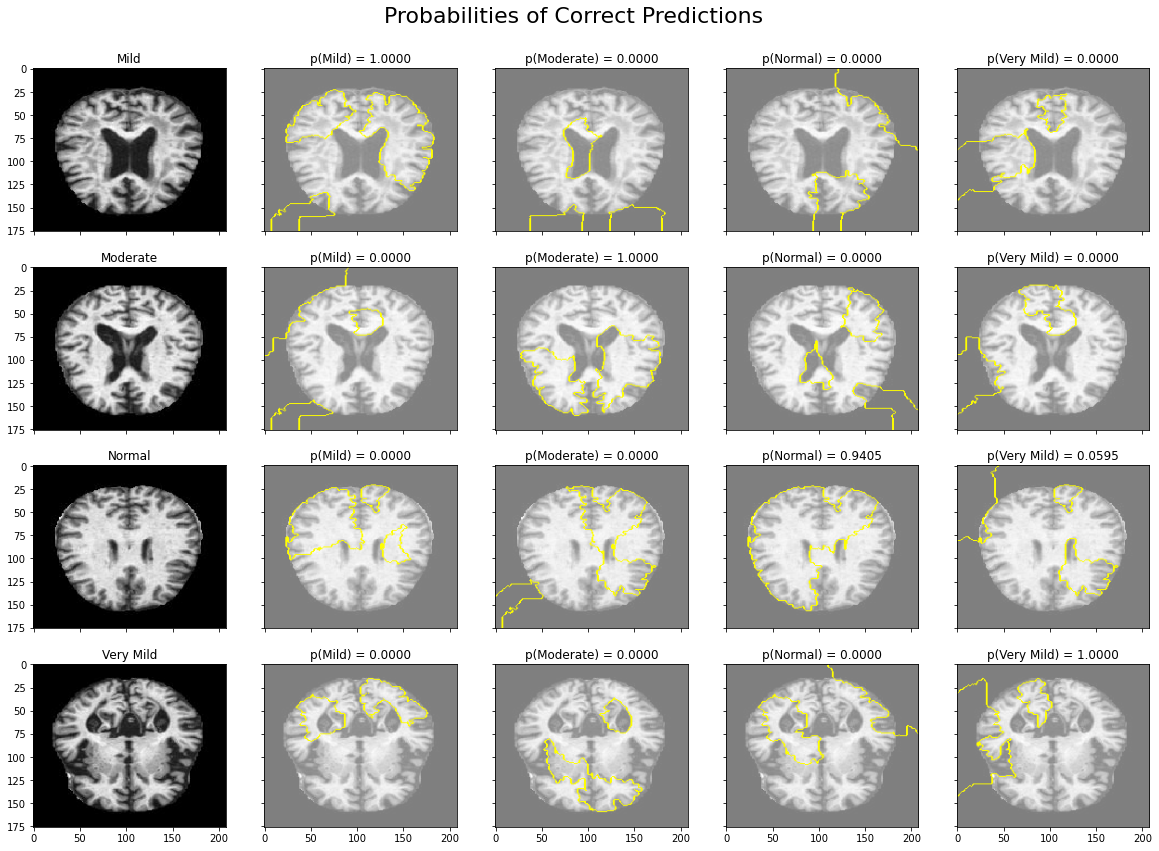

In [107]:
ncols = 5
nrows = 4 

corrects = np.nonzero(y_pred == test_generator.classes)[0] # list of all indecies our model got wrong 
correct_ind = corrects[[1,136,200,800]] # Selected images from each class


fig, ax = plt.subplots(nrows, ncols, sharex='col', sharey='row')
fig.set_figwidth(20)
fig.set_figheight(14)
fig.suptitle('Probabilities of Correct Predictions', fontsize = 22, y = .94)

for j in range(nrows):
    explanation = explainer.explain_instance(a[correct_ind][j], 
                                             model.predict, 
                                             top_labels=4, hide_color=0, num_samples=200, 
                                             random_seed=42)
    ax[j,0].imshow(a[correct_ind][j])
    ax[j,0].set_title(class_name[test_generator.classes[correct_ind][j]])
    for i in range(ncols - 1):
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                    num_features=3, hide_rest=False)
        ax[j,i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
        ax[j,i+1].set_title('p({}) = {:.4f}'.format(class_name[i], Y_pred[correct_ind[j]][i]))

plt.savefig(f'../report/figures/Lime_correct_preds', dpi = 100)

# Takeaways

I created a Model that will predict the severity of Alzheimer’s very well and ideally methods similar to this will be implemented to help MRI technicians and doctors alike when diagnosing Alzhiemer's. MRI Scans are one of the many test in diagnosing Alzheimers, and machine learning is able to help improve that. As long as Brain imaging and machine learning evolve it will be easier to diagnose patients earlier and intervene appropriately.